In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import torch.utils.data as data
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
import time

from torchsummary import summary

from sklearn.model_selection import train_test_split

from torch.utils.data.sampler import SubsetRandomSampler

######### SET PARAMETERS #########
bs = 4
lr = 0.1
epochs = 100
seed = 0
N=10
split = 0.2

#Reproducability
torch.manual_seed(seed)

In [2]:
#Compute mean and standard deviation of a dataset 

#METHOD 1
def dataset_mean_std(loader):
    mean = 0.0
    std = 0.0
    var = 0.0
    for image, label in loader:
        #image (10,3,56,56)
        #label (10)

        image = image.view(image.size(0), image.size(1), -1) 
        mean = mean + image.mean(2).sum(0)
        var = var + image.var(2).sum(0)

    mean = mean / len(loader.dataset)
    var = var / len(loader.dataset)
    std = torch.sqrt(var)
    
    return mean, std

#METHOD 2 (less accurate)
#data = next(iter(rawloader))
#print(data[0].mean(), data[0].std())


In [3]:
######## LOADS AND SPLITS TRAIN, VALID DATA ########
def load_data(batch_size, split): 

    full = datasets.ImageFolder(root='training_v2/',transform = transforms.ToTensor()) 
    print(full)
    full_loader = data.DataLoader(full,batch_size = len(full), shuffle=True)    
    
    #Calculate mean of full dataset 
    mean, std = dataset_mean_std(full_loader) 
    print(mean,std)

    #Normalize the full dataset
    trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean,std)])
    
    #Define train & test datasets (just copies of the normalized full, to be split in the next lines)
    train = torchvision.datasets.ImageFolder(root='training_v2/', transform = trans)
    test = torchvision.datasets.ImageFolder(root='training_v2/', transform = trans) 

    #Split normalized train & test 
    idxs = list(range(len(train))) #create indices from 0 to the number of training data
    split = int(np.floor(split * len(train))) #rounded up to closest integers
    
    np.random.shuffle(idxs) #shuffle the numbers of the indices (so train and test are split randomly)

    train_idx, test_idx = idxs[split:], idxs[:split]

    train_samp = SubsetRandomSampler(train_idx) #randomly assigning samples to train/test
    test_samp = SubsetRandomSampler(test_idx)

    trainloader = data.DataLoader(train, sampler = train_samp, batch_size=batch_size)
    testloader = data.DataLoader(test, sampler = test_samp, batch_size=batch_size)

    return trainloader, testloader #randomly split data 


In [4]:
######## DEFINE CNN CLASS ########
class CNN(nn.Module): ####################################################################################
    def __init__(self):
        super(CNN, self).__init__()
        #NUMBER OF KERNALS (10,30)
        self.conv1 = nn.Conv2d(3, 30, 3) #(rgb channels, kernels, size of kernels 3x3) <-- stride = 1 by default
        self.pool = nn.MaxPool2d(2, 2) #(size 2x2, stride 2)
        self.conv1_BN = nn.BatchNorm2d(30)
        
        self.conv2 = nn.Conv2d(30, 30, 3) #(input channels = output feature map from first layer) 
        self.conv2_BN = nn.BatchNorm2d(30)
        
        self.conv3 = nn.Conv2d(30, 30, 3)
        self.conv3_BN = nn.BatchNorm2d(30)
        
        self.conv4 = nn.Conv2d(30, 30, 3)
        self.conv4_BN = nn.BatchNorm2d(30)


        
        #NUMBER OF NEURONS 8,32
        self.fc1 = nn.Linear(30,32) #(8x5x5 = 200 inputs for each neuron, 100 neurons) #INPUT= SIZE OF LAST POOL (-,1,2,3)
        self.fc2 = nn.Linear(32, 10) #(100 input neurons, 10 outputs/classes)
        
        self.fc1_BN = nn.BatchNorm1d(32)

    def forward(self, x): #x is input 
        x = F.relu(self.conv1_BN(self.conv1(x))) #(#,#,#,#)
        #print("1",x.shape)
        x = self.pool(x) 
        #print("2",x.shape)

        x = F.relu(self.conv2_BN(self.conv2(x))) 
        #print("3",x.shape)
        x = self.pool(x) 
        #print("4",x.shape)
   #####      
        x = F.relu(self.conv3_BN(self.conv3(x))) 
        #print("3",x.shape)
        x = self.pool(x) 
        #print("4",x.shape)
        
        x = F.relu(self.conv4_BN(self.conv4(x))) 
        #print("3",x.shape)
        x = self.pool(x) 
        #print("4",x.shape)
    #####
        x = x.view(-1, 30) #(10,968) #OUTPUT= SIZE OF LAST POOL (-,1 2 3) #########
        #print("5",x.shape)

        x = self.fc1_BN(self.fc1(x)) #(10,100) 
        #print("6",x.shape)
        x = self.fc2(x) #(10,10)
        #print("7",x.shape)

        return x

In [5]:
######## INSTANTIATE MODEL, DEFINE LOSS FCN & OPTIMIZER ########
def load_model(learning_rate):
    
    model = CNN() 
    loss_fnc = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate) 

    return model, loss_fnc, optimizer

In [6]:
######## CALCULATES BATCHACC (in training) ########
def accuracy(predictions, labels):
    correct = 0 
    total = 0
    
    _, predicted = torch.max(predictions,1) #finds max, returns index of max (predicted label)
    total = total + len(labels) 
    correct = correct + (predicted.float() == labels).sum() 


    batchacc = correct.item() / total
    return batchacc
    

In [7]:
######## CALCULATES VALIDATION ACC & LOSS (at end of each epoch) ########
def evaluate(model, val_loader):
    correct = 0 
    total = 0 
    
    batchloss_accum = 0.0
    
    for i,data in enumerate(val_loader,0): #go through each batch in val_loader
        inputs, labels = data
        predictions = model(inputs.float()) #tensor size bs --> grad_fnc = sigmoidbackward    
        
        #Calculate accuracy 
        _, predicted = torch.max(predictions,1) #finds max, returns index of max (predicted label)
        total = total + len(labels) 
        
        correct = correct + (predicted.float() == labels.float()).sum() 
        acc = correct.item() / total
        
        #Calculate loss
        labels_oh = F.one_hot(labels,10)
        loss = loss_fnc(predictions, labels_oh.float())
        batchloss_accum = batchloss_accum + batchloss.item()
        
        
    avgbatchloss = batchloss_accum/len(train_loader)

    return acc, avgbatchloss
        


In [8]:
torch.manual_seed(seed)

#LOAD DATA 
train_loader,val_loader = load_data(bs,split) 
model,loss_fnc,optimizer = load_model(lr) #learning rate (lr)s defined here 

#STORE FOR PLOTTING
loss_list = []
acc_list = []
nepoch = []

testacc_list = []
testloss_list = []

#Training loop 
start_time = time.time()
for e in range(epochs): 
    nepoch = nepoch + [e]

    batchloss_accum = 0.0
    batchacc_accum = 0.0

    for i, data in enumerate(train_loader, 0): #len trainloader is number of batches 
        model.train() 
        correct = 0 
        total = 0 #10-30
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data #inputs = (10,3,56,56); labels = (10)
        labels_oh = F.one_hot(labels,10)

        inputs = Variable(inputs).float()
        labels = Variable(labels).float()

        # Zero parameter gradients
        optimizer.zero_grad()

        #Run model on inputs
        #outputs = torch.sigmoid(CNNmodel(inputs)) #(10,10)
        outputs = model(inputs) #(10,10)

        #Compute loss
        batchloss = loss_fnc(outputs, labels_oh.float())
        batchloss.backward()
        optimizer.step()

        batchloss_accum = batchloss_accum + batchloss.item() #added values of loss for all batches
        #print('batchloss',batchloss)

        batchacc = accuracy(outputs,labels)
        batchacc_accum = batchacc_accum + batchacc
        #print("Batch accuracy",batchacc)

        if i == len(train_loader)-1: #len(trainloader) is len(dataset) / images per batch
            model.eval() 
            vacc, vloss = evaluate(model,val_loader)
            
            print("avg acc/epoch", batchacc_accum/len(train_loader))
            print('[%d, %5d] avg loss/epoch: %.3f' % (e + 1, i + 1, batchloss_accum/len(train_loader)))
            print("validation loss:", vloss)
            print("validation acc:", vacc)
            
            loss_list = loss_list + [batchloss_accum/len(train_loader)]
            acc_list = acc_list + [batchacc_accum/len(train_loader)]
            testacc_list.append(vacc)   
            testloss_list.append(vloss)

            batchloss_accum = 0.0
            batchacc_accum = 0.0 


endtime = time.time() - start_time
print('Finished Training')
print("Execution time", endtime)

Dataset ImageFolder
    Number of datapoints: 3815
    Root location: training_v2/
    StandardTransform
Transform: ToTensor()
tensor([0.6876, 0.6190, 0.5674]) tensor([0.1352, 0.1674, 0.1785])
avg acc/epoch 0.2870249017038008
[1,   763] avg loss/epoch: 0.095
validation loss: 0.021175895867622696
validation acc: 0.5150720838794234
avg acc/epoch 0.4596985583224115
[2,   763] avg loss/epoch: 0.078
validation loss: 0.017000816117967252
validation acc: 0.653997378768021
avg acc/epoch 0.573394495412844
[3,   763] avg loss/epoch: 0.069
validation loss: 0.01651192476013541
validation acc: 0.7169069462647444
avg acc/epoch 0.6707077326343381
[4,   763] avg loss/epoch: 0.061
validation loss: 0.01750523804993336
validation acc: 0.7758846657929227
avg acc/epoch 0.7214941022280472
[5,   763] avg loss/epoch: 0.057
validation loss: 0.014030156918309463
validation acc: 0.836173001310616
avg acc/epoch 0.7536041939711664
[6,   763] avg loss/epoch: 0.054
validation loss: 0.011204307686493562
validation ac

avg acc/epoch 0.9593709043250328
[59,   763] avg loss/epoch: 0.031
validation loss: 0.004684327126310975
validation acc: 0.9344692005242464
avg acc/epoch 0.9560943643512451
[60,   763] avg loss/epoch: 0.031
validation loss: 0.005018650384456271
validation acc: 0.9305373525557011
avg acc/epoch 0.9636304062909568
[61,   763] avg loss/epoch: 0.031
validation loss: 0.010679907881963612
validation acc: 0.927916120576671
avg acc/epoch 0.9538007863695938
[62,   763] avg loss/epoch: 0.032
validation loss: 0.007443261255911731
validation acc: 0.927916120576671
avg acc/epoch 0.9479030144167759
[63,   763] avg loss/epoch: 0.032
validation loss: 0.008488837063195353
validation acc: 0.9305373525557011
avg acc/epoch 0.9652686762778506
[64,   763] avg loss/epoch: 0.031
validation loss: 0.008153121518081013
validation acc: 0.9370904325032765
avg acc/epoch 0.9613368283093053
[65,   763] avg loss/epoch: 0.031
validation loss: 0.0077461167769616425
validation acc: 0.9305373525557011
avg acc/epoch 0.96428

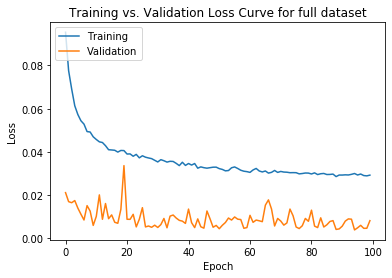

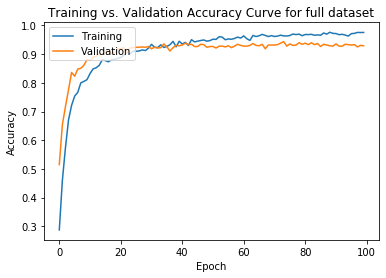

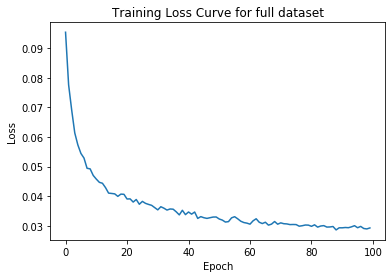

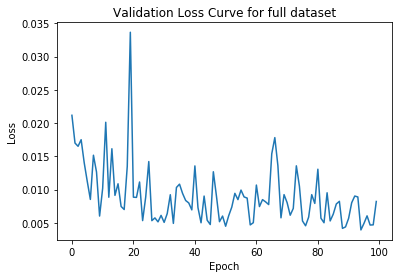

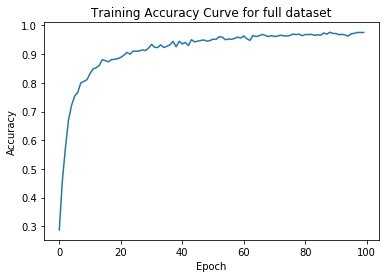

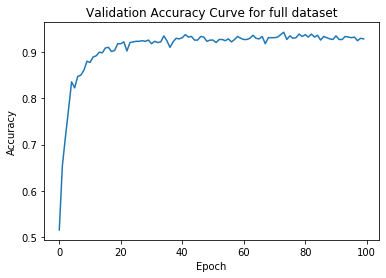

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 30, 54, 54]             840
       BatchNorm2d-2           [-1, 30, 54, 54]              60
         MaxPool2d-3           [-1, 30, 27, 27]               0
            Conv2d-4           [-1, 30, 25, 25]           8,130
       BatchNorm2d-5           [-1, 30, 25, 25]              60
         MaxPool2d-6           [-1, 30, 12, 12]               0
            Conv2d-7           [-1, 30, 10, 10]           8,130
       BatchNorm2d-8           [-1, 30, 10, 10]              60
         MaxPool2d-9             [-1, 30, 5, 5]               0
           Conv2d-10             [-1, 30, 3, 3]           8,130
      BatchNorm2d-11             [-1, 30, 3, 3]              60
        MaxPool2d-12             [-1, 30, 1, 1]               0
           Linear-13                   [-1, 32]             992
      BatchNorm1d-14                   

In [11]:
#LOSS TOGETHER
plt.plot(nepoch,loss_list, label = 'Train')
plt.plot(nepoch,testloss_list, label = 'Valid')
plt.xlabel("Epoch")
plt.ylabel("Loss") 
plt.title("Training vs. Validation Loss Curve for full dataset")
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show() 

#ACCURACIES TOGETHER
plt.plot(nepoch,acc_list, label = 'Train')
plt.plot(nepoch,testacc_list, label = 'Validation')
plt.xlabel("Epoch")
plt.ylabel("Accuracy") 
plt.title("Training vs. Validation Accuracy Curve for full dataset")
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show() 

#TRAIN LOSS 
plt.plot(nepoch,loss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss") 
plt.title("Training Loss Curve for full dataset")
plt.show() 

#VALID LOSS
plt.plot(nepoch,testloss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss") 
plt.title("Validation Loss Curve for full dataset")
plt.show() 

#TRAIN ACC
plt.plot(nepoch,acc_list)
plt.xlabel("Epoch")
plt.ylabel("Accuracy") 
plt.title("Training Accuracy Curve for full dataset")
plt.show() 


#VALID ACC
plt.plot(nepoch,testacc_list)
plt.xlabel("Epoch")
plt.ylabel("Accuracy") 
plt.title("Validation Accuracy Curve for full dataset")
plt.show() 


summary(model, input_size=(3, 56, 56))